In [11]:
import torch
from torch import nn

m = nn.Conv2d(256, 128, kernel_size=3, padding=1, groups=1, stride=1)
input = torch.randn(1, 256, 64, 64)
output = m(input)
print(output.shape)

torch.Size([1, 128, 64, 64])


In [3]:
%cd my_framework_1/content_encoder/modules

import torch
from net_module import AntiAliasInterpolation2d

m = AntiAliasInterpolation2d(3, 0.25)
input = torch.randn(1, 3, 256, 256)
output = m(input)
print(output.shape)

[Errno 2] No such file or directory: 'my_framework_1/content_encoder/modules'
/root/TalkingHead/my_framework_1/content_encoder/modules
torch.Size([1, 3, 64, 64])


In [4]:
%cd my_framework_1/content_encoder/modules

import torch
from net_module import Hourglass

m = Hourglass(32, in_features=3, max_features=1024, num_blocks=5)
input = torch.randn(1, 3, 64, 64)
output = m(input)
print(output.shape)

[Errno 2] No such file or directory: 'my_framework_1/content_encoder/modules'
/root/TalkingHead/my_framework_1/content_encoder/modules
torch.Size([1, 35, 64, 64])


In [1]:
%cd my_framework_1/content_encoder/modules

import torch
from net_module import OcclusionAwareGenerator

dense_motion_params = {
    "block_expansion":64,
    "num_blocks": 5,
    "max_features": 1024,
    # "num_kp": 10,
    # "num_channels": 3,
    # "estimate_occlusion_map": True,
    "scale_factor": 0.25
}
#(64,5,1024,10,3,True,0.25,0.01)

m = OcclusionAwareGenerator(3, 10, block_expansion=64, max_features=512, num_down_blocks=2,
                 num_bottleneck_blocks=6, estimate_occlusion_map=True, 
                 dense_motion_params=dense_motion_params, estimate_jacobian=True)
source_image = torch.randn(1, 3, 256, 256)
kp_driving = {
    "heatmap": torch.randn(1, 10, 58, 58),
    "jacobian": torch.randn(1, 10, 2, 2),
    "value": torch.randn(1, 10, 2)
}
kp_source = {
    "heatmap": torch.randn(1, 10, 58, 58),
    "jacobian": torch.randn(1, 10, 2, 2),
    "value": torch.randn(1, 10, 2)
}
output = m(source_image, kp_driving, kp_source)
print(output["mask"].shape)
print(output["sparse_deformed"].shape)
print(output["occlusion_map"].shape)
print(output["deformed"].shape)
print(output["prediction"].shape)

/root/TalkingHead/my_framework_1/content_encoder/modules
torch.Size([1, 11, 64, 64])
torch.Size([1, 11, 3, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


/root/miniconda3/envs/talkinghead/lib/python3.8/site-packages/torch/nn/functional.py:3981: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/root/miniconda3/envs/talkinghead/lib/python3.8/site-packages/torch/nn/functional.py:3609: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


In [1]:
%cd ~/TalkingHead/my_framework_1/content_encoder/modules

import torch
from net_module import KPDetector, KPDetector_a, AT_net2, Emotion_k, OcclusionAwareGenerator

kp_detector_params = {
    "temperature": 0.1,
    "block_expansion": 32,
    "max_features": 1024,
    "scale_factor": 0.25,
    "num_blocks": 5
}

common_params = {
    "num_kp": 10,
    "num_channels": 3,
    "estimate_jacobian": True
}

audio_params = {
    "num_kp": 10,
    "num_channels" : 3,
    "num_channels_a" : 3,
    "estimate_jacobian": True
}

dense_motion_params = {
    "block_expansion":64,
    "num_blocks": 5,
    "max_features": 1024,
    "scale_factor": 0.25
}

kp_detector = KPDetector(**kp_detector_params,**common_params)
kp_detector_a = KPDetector_a(**kp_detector_params,**audio_params)
audio_feature = AT_net2()
emo_detector = Emotion_k(block_expansion=32, num_channels=3, max_features=1024,
                 num_blocks=5, scale_factor=0.25, num_classes=8)
generator = OcclusionAwareGenerator(3, 10, block_expansion=64, max_features=512, num_down_blocks=2,
                 num_bottleneck_blocks=6, estimate_occlusion_map=True, 
                 dense_motion_params=dense_motion_params, estimate_jacobian=True)
if torch.cuda.is_available():
    kp_detector.to("cuda:0")
    kp_detector_a.to("cuda:0")
    audio_feature.to("cuda:0")
    emo_detector.to("cuda:0")
    generator.to("cuda:0")



/root/TalkingHead/my_framework_1/content_encoder/modules


In [2]:
checkpoint = torch.load('/root/TalkingHead/log/124_52000.pth.tar')
audio_checkpoint = torch.load('/root/TalkingHead/log/1-6000.pth.tar')
emo_checkpoint = torch.load('/root/TalkingHead/log/5-3000.pth.tar')

generator.load_state_dict(checkpoint['generator'])
kp_detector.load_state_dict(checkpoint['kp_detector'])
audio_feature.load_state_dict(audio_checkpoint['audio_feature'])
kp_detector_a.load_state_dict(audio_checkpoint['kp_detector_a'])
emo_detector.load_state_dict(emo_checkpoint['emo_detector'])

generator.eval()
kp_detector.eval()
audio_feature.eval()
kp_detector_a.eval()
emo_detector.eval()

Emotion_k(
  (predictor): Hourglass(
    (encoder): Encoder(
      (down_blocks): ModuleList(
        (0): DownBlock2d(
          (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (pool): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
        )
        (1): DownBlock2d(
          (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (pool): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
        )
        (2): DownBlock2d(
          (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (pool): AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
        )
        (3): DownBlock2d(


In [28]:
source_image_file = '/root/TalkingHead/test/image/7.png'
driving_video_file = '/root/TalkingHead/test/video/disgusted.mp4'
pose_file = '/root/TalkingHead/test/pose/7.npy'
# pose_given = '/root/TalkingHead/test/pose_long/0zn70Ak8lRc_Daniel_Auteuil_0zn70Ak8lRc_0002.npy'
in_file = '/root/TalkingHead/test/audio/sample1.mov'

In [29]:
%cd /root/TalkingHead/my_framework_1/content_encoder/modules

import dlib
import numpy as np
import cv2
from skimage import transform as tf
import imageio
from util_module import AllAugmentationTransform

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/root/mlxtend_data/shape_predictor_68_face_landmarks.dat')

def shape_to_np(shape, dtype="int"):
    # initialize the list of (x, y)-coordinates
    coords = np.zeros((shape.num_parts, 2), dtype=dtype)

    # loop over all facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    for i in range(0, shape.num_parts):
        coords[i] = (shape.part(i).x, shape.part(i).y)

    # return the list of (x, y)-coordinates
    return coords

def get_aligned_image(driving_video, emotion):
    aligned_array = []

    video_array = np.array(driving_video)
    source_image=video_array[0]
   # aligned_array.append(source_image)
    source_image = np.array(source_image * 255, dtype=np.uint8)
    gray = cv2.cvtColor(source_image, cv2.COLOR_BGR2GRAY)
    rects = detector(gray, 1)  #detect human face
    for (i, rect) in enumerate(rects):
        template = predictor(gray, rect) #detect 68 points
        template = shape_to_np(template)

    if emotion == 'surprised' or emotion == 'fear':
        template = template-[0,10]
    for i in range(len(video_array)):
        image=np.array(video_array[i] * 255, dtype=np.uint8)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        rects = detector(gray, 1)  #detect human face
        for (j, rect) in enumerate(rects):
            shape = predictor(gray, rect) #detect 68 points
            shape = shape_to_np(shape)

        pts2 = np.float32(template[:35,:])
        pts1 = np.float32(shape[:35,:]) #eye and nose

    #    pts2 = np.float32(np.concatenate((template[:16,:],template[27:36,:]),axis = 0))
    #    pts1 = np.float32(np.concatenate((shape[:16,:],shape[27:36,:]),axis = 0)) #eye and nose
        # pts1 = np.float32(landmark[17:35,:])
        tform = tf.SimilarityTransform()
        tform.estimate( pts2, pts1) #Set the transformation matrix with the explicit parameters.
        dst = tf.warp(image, tform, output_shape=(256, 256))

        dst = np.array(dst, dtype=np.float32)
        aligned_array.append(dst)

    return aligned_array

augmentation_params = {
    'flip_param': {
        'horizontal_flip': False,
        'time_flip': False
    },
    'jitter_param': {
        'brightness': 0.1,
        'contrast': 0.1,
        'saturation': 0.1,
        'hue': 0.1
    },
}
def get_transformed_image(driving_video):
    video_array = np.array(driving_video)
    transformations = AllAugmentationTransform(**augmentation_params)
    transformed_array = transformations(video_array)
    return transformed_array

reader = imageio.get_reader(driving_video_file)
fps = reader.get_meta_data()['fps']
driving_video = []
try:
    for im in reader:
        driving_video.append(im)
except RuntimeError:
    pass
reader.close()

from skimage.transform import resize
from skimage import io, img_as_float32

driving_video = [resize(frame, (256, 256))[..., :3] for frame in driving_video]
driving_video = get_aligned_image(driving_video, 'disgusted')
transformed_video = get_transformed_image(driving_video)
transformed_video = np.array(transformed_video)
print(transformed_video.shape)

/root/TalkingHead/my_framework_1/content_encoder/modules
(203, 256, 256, 3)


In [30]:
import numpy as np

input_mfcc = []
for i in range(1, 70):
    mfcc_path = f'/root/Datasets/Features/M003/mfccs/disgusted/level_3/00001/{i:05d}.npy'
    mfcc_data = np.load(mfcc_path)
    mfcc_data = torch.FloatTensor(mfcc_data).to("cuda:0")
    input_mfcc.append(mfcc_data)
input_mfcc = torch.stack(input_mfcc, dim=0)
input_mfcc = input_mfcc.unsqueeze(0)
print(input_mfcc.shape)

torch.Size([1, 69, 28, 12])


In [31]:
import numpy as np
from torch.autograd import Variable
all_pose = np.load(pose_file)
pose = all_pose[:,:6]
if len(pose) == 1:
    pose = np.repeat(pose,input_mfcc.shape[1],0)
pose = Variable(torch.FloatTensor(pose.astype(float)) ).to("cuda:0")
pose = pose.unsqueeze(0)
print(pose.shape)

torch.Size([1, 69, 6])


In [32]:
from skimage.transform import resize
from skimage import io, img_as_float32
from torch.autograd import Variable

source_image = img_as_float32(io.imread(source_image_file))
source_image = resize(source_image, (256, 256))[..., :3]
print(source_image.shape)
example_image = np.array(source_image, dtype='float32').transpose((2, 0, 1))
example_image = Variable(torch.FloatTensor(example_image.astype(float)) ).to("cuda:0")
example_image = torch.unsqueeze(example_image,0)
print(example_image.shape)

(256, 256, 3)
torch.Size([1, 3, 256, 256])


In [33]:
deco_out = audio_feature(example_image,input_mfcc,pose,'cnn',1.6)
print(deco_out.shape)

torch.Size([1, 69, 35, 64, 64])


In [45]:
%cd /root/TalkingHead/my_framework_1/content_encoder/modules

import os
from skimage import img_as_ubyte
from util_module import make_animation_smooth

predictions, _ = make_animation_smooth(source_image, driving_video, transformed_video, deco_out, 0, generator, kp_detector, kp_detector_a, emo_detector, False, relative=False, adapt_movement_scale=False, cpu=False)
imageio.mimsave(os.path.join('/root/TalkingHead/','neutral.mp4'), [img_as_ubyte(frame) for frame in predictions], fps=15)

/root/TalkingHead/my_framework_1/content_encoder/modules


100%|██████████| 69/69 [00:02<00:00, 30.00it/s]


In [35]:
import numpy as np

driving_images = []
for i in range(1, 18):
    image_path = f'/root/Datasets/Features/M003/images/disgusted/level_1/00001/{i:05d}.jpg'
    image = img_as_float32(io.imread(image_path))
    image = resize(image, (256, 256))[..., :3]
    image = np.array(image, dtype='float32').transpose((2, 0, 1))
    image = Variable(torch.FloatTensor(image.astype(float)) ).to("cuda:0")
    driving_images.append(image)
    
driving_images = torch.stack(driving_images, dim=0)
driving_images = driving_images.unsqueeze(0)
print(driving_images.shape)

torch.Size([1, 17, 3, 256, 256])


In [36]:
kp_source = kp_detector(example_image)
print('kp_source')
print(kp_source["jacobian"].shape)
print(kp_source["heatmap"].shape)
print(kp_source["value"].shape)
kp_driving = []
kp_driving_a = [] 
for i in range(17):
    kp_driving.append(kp_detector(driving_images[:,i]))
    kp_driving_a.append(kp_detector_a(deco_out[:,i]))
print('kp_driving')
print(kp_driving[0]["jacobian"].shape)
print(kp_driving[0]["heatmap"].shape)
print(kp_driving[0]["value"].shape)
print('kp_driving_a')
print(kp_driving_a[0]["jacobian"].shape)
print(kp_driving_a[0]["heatmap"].shape)
print(kp_driving_a[0]["value"].shape)


kp_source
torch.Size([1, 10, 2, 2])
torch.Size([1, 10, 58, 58])
torch.Size([1, 10, 2])
kp_driving
torch.Size([1, 10, 2, 2])
torch.Size([1, 10, 58, 58])
torch.Size([1, 10, 2])
kp_driving_a
torch.Size([1, 10, 2, 2])
torch.Size([1, 10, 58, 58])
torch.Size([1, 10, 2])


In [39]:
output = generator(example_image, kp_source, kp_driving_a[10])
print(output["mask"].shape)
print(output["sparse_deformed"].shape)
print(output["occlusion_map"].shape)
print(output["deformed"].shape)
print(output["prediction"].shape)

torch.Size([1, 11, 64, 64])
torch.Size([1, 11, 3, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 3, 256, 256])
torch.Size([1, 3, 256, 256])


(256, 256, 3)


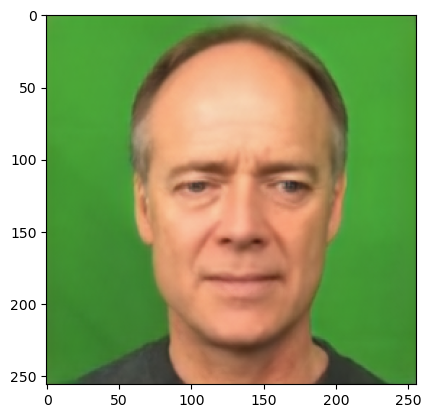

In [40]:
import matplotlib.pyplot as plt

img = output["prediction"][0]
img = img.cpu().detach().numpy()
img = img.transpose((1, 2, 0))
print(img.shape)
plt.imshow(img)

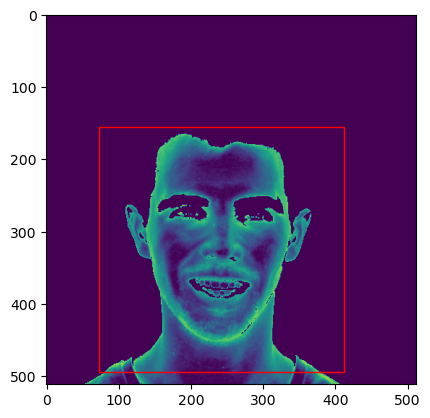

In [66]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import json

file_path = '/root/Datasets/Features/M003/images/happy/level_1/00001/00010.jpg'
image = cv2.imread(file_path)
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(image_gray, 100, 255, cv2.THRESH_BINARY)
image_copy = image.copy()
image_copy = image_copy[:,:,2] * thresh

lm_path = file_path.replace('images', 'landmarks74')
lm_path = lm_path.replace('jpg', 'json')
with open(lm_path, 'rt') as f:
    lm_data = json.load(f)
    lm_bb = lm_data['bb']
fig, ax = plt.subplots()
ax.imshow(image_copy)
rect = patches.Rectangle((lm_bb[0],lm_bb[1]), lm_bb[2]-lm_bb[0], lm_bb[3] - lm_bb[1], linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.show()

In [ ]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import json

file_path = '/root/Datasets/Features/M003/images/happy/level_1/00001/00010.jpg'
image = cv2.imread(file_path)
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(image_gray, 100, 255, cv2.THRESH_BINARY)
image_copy = image.copy()
image_copy = image_copy[:,:,2] * thresh

lm_path = file_path.replace('images', 'landmarks74')
lm_path = lm_path.replace('jpg', 'json')
with open(lm_path, 'rt') as f:
    lm_data = json.load(f)
    lm_bb = lm_data['bb']
fig, ax = plt.subplots()
ax.imshow(image_copy)
rect = patches.Rectangle((lm_bb[0],lm_bb[1]), lm_bb[2]-lm_bb[0], lm_bb[3] - lm_bb[1], linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.show()

In [1]:
%cd /root/TalkingHead/my_framework_1/content_encoder

import torch
from modules.net_module import UNet

#(type, input, output, kernel, padding, stride)
encoder_params = [
    ('same', 1, 64),    #(256,256,64)
    ('down', 64, 64),   #(128,128,64)
    ('down', 64, 128),  #(64,64,128)
    ('down', 128, 256), #(32,32,256)
    ('down', 256, 512), #(16,16,512)
    ('down', 512, 512), #(8,8,512)
    ('down', 512, 512), #(4,4,512)
    ('down', 512, 512), #(2,2,512)
]
decoder_params = [
    ('up', 512, 512),   #(4,4,512)
    ('up', 512*2, 512),   #(8,8,512)
    ('up', 512*2, 512),   #(16,16,512)
    ('up', 512*2, 256),   #(32,32,256)
    ('up', 256*2, 128),   #(64,64,128)
    ('up', 128*2, 64),    #(128,128,64)
    ('up', 64*2, 64),     #(256,256,64)
    ('same', 64*2, 1),    #(256,256,1)
]

m = UNet(encoder_params=encoder_params, decoder_params=decoder_params)
source_image = torch.randn(1, 1, 256, 256)
output = m(source_image)
print(output.shape)


/root/TalkingHead/my_framework_1/content_encoder
torch.Size([1, 1, 256, 256])
